# Unsaturated Zone Module Testing

In this notebook we perform some tests to validate the unsaturated zone module applied in GWTSA for non-linear time serie models. Two models have been applied, however this notebook only considers the percolation models to serve as an example:

(1)\begin{equation}
\frac{dS}{dt} = (P-I)- K_{sat}\left( \frac{S(t)}{S_{cap}}\right) ^\beta - E_p min(1, \frac{S}{0.5S_{cap}})
\end{equation}

This non-linear differential equation cannot be solved analytically and is therefore solved numerically. Details on the mathematics can be found in the Appendix of the Documentation of GWTSA `GWTSA_Manual.pdf`. Testing of the numerical model is important to validate that the code does what it should do. 

#### The following tests are used:
- Analytical solution versus the numerical solution
- Use of a numerical model to check emptying and filling of the unsaturated zone (check model logics)
- Random forcings to check model under different conditions
- Comparison of the python script and the cythonized script (C-language)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
import pstats, cProfile
from GWTSA import *
print 'packages succesfully imported!'
%matplotlib inline

packages succesfully imported!


In [27]:
#Test Some potential functions
10.0**-2.0


0.01

### 1. ANALYTICAL SOLUTION VS. NUMERICAL SOLUTION
As stated above, solving the unsaturated zone model is not trivial. However, under certain conditions equation $(1)$ can be simplyfied such that it can be solved analytically. This provides a way to compare the numerical solution to the analytical solution. In this example we test the unsaturated zone model for the case where the precipitation and the evapotranspiration are both equal to zero. Equation $(1)$ then simplifies to:

\begin{equation}
\frac{dS}{dt} = - K_{sat}\left( \frac{S(t)}{S_{cap}}\right) ^\beta
\end{equation}

Which, when we make $\beta=1.0$, we can solve this equation analytically:

\begin{equation}
S(t) = S_0 e^{\frac{-K_{sat}t}{S_{cap}}}
\end{equation}

We now create a timeseries of evaporation and precipitation equal to zero and define the parameter $\beta=0$ as input data for the percolation model.

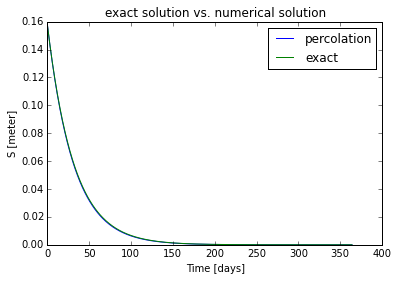

In [28]:
# Provide the forcings precipitation and potential evapotransapiration
n = 365
P = np.zeros(n)
E = np.zeros(n)

# Provide the model parameters for the soil module
S_cap = -0.5 # is equal to ±30 milimeters
K_sat = -2.0 # is equal to 0.01 m/d
Beta = 1.0
D = -3.0

# Provide some details for the timesteps to calculate the soil state
t = np.arange(0,n,1)
dt= 1

S0 = 0.5 * 10.0**S_cap # Calculate the initial soil state (assumed to be half full)
S = Unsat_Zone.percolation(t, P, E, S_cap, K_sat, Beta, D, dt)[1]; #1 index return the soil state S
S2 = S0 * np.exp((-10.0**K_sat)*t/(10.0**S_cap)) #Plot the exact solution when P and E are zero and Beta=1

# Make a plot of the two solutions for visual comparison
plt.plot(t,S)
plt.plot(t,S2)
plt.legend(['percolation', 'exact'], loc = 'best')
plt.ylabel('S [meter]')
plt.xlabel('Time [days]')
plt.title('exact solution vs. numerical solution')

### 2. EMPTYING AND FILLING THE UNSATURATED ZONE

In this example we investigate the filling and emptying of the unsaturated zone. The unsaturated zone has certain physical boundaries, as it cannot reveal negative values and it cannot contain more than a certain amount of water when it is saturated. In this example, we model the situation where the unsaturated zone is full and where it is empty, to validate that the the amount of water cannot excess the soil capacity $S_{cap}$ and cannot go below zero. We therefore first consider half a year with very wet conditions, followed by half a year with no rain.

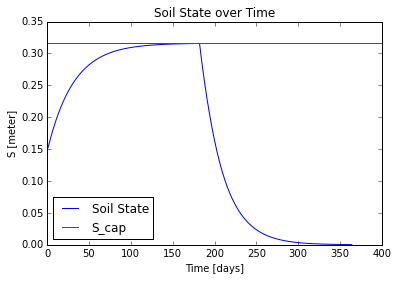

In [38]:
P = np.zeros(n)
P[:int(365/2.0)] = 11.0 / 1000 # All forcings must be provided in meters
E = 0.001 * np.ones(n)

S = Unsat_Zone.percolation(t, P, E, S_cap, K_sat, Beta, D, dt)[1]

plt.plot(t,S)
plt.ylabel('S [meter]')
plt.xlabel('Time [days]')
plt.axhline(10.0**S_cap, color='r')
plt.legend(['Soil State', 'S_cap'], loc='best')
plt.title('Soil State over Time')


### 3. RANDOM FORCINGS


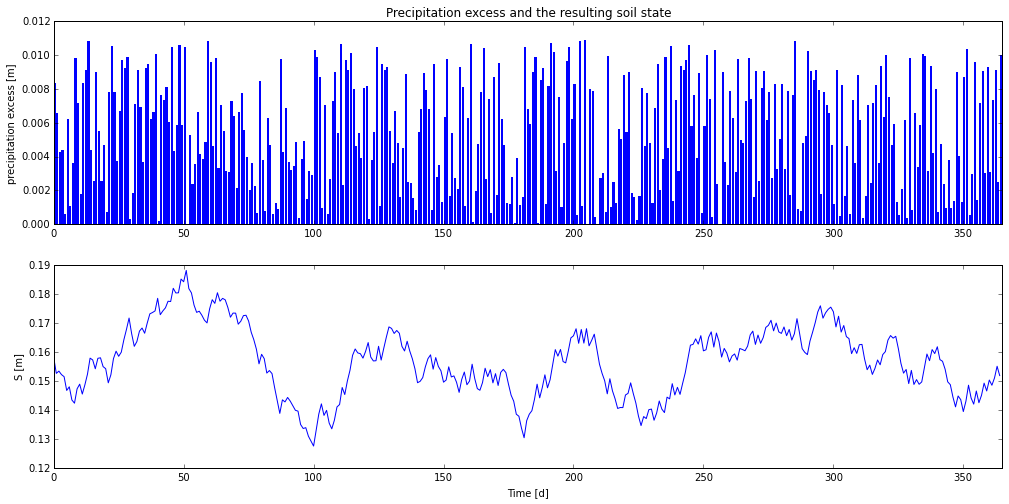

In [41]:
# Provide the forcings precipitation and potential evapotransapiration
P = 0.011 * np.random.rand(n)
E = 0.001 * np.random.rand(n)

S = Unsat_Zone.percolation(t, P, E, S_cap, K_sat, Beta, D, dt)[1]

# Bar plot of the precipitation excess
plt.figure(figsize=(17,8))
plt.subplot(211)
plt.bar(t, (P-E), lw=0)
plt.xlim(0, n); plt.ylim(0)
plt.title('Precipitation excess and the resulting soil state')
plt.ylabel('precipitation excess [m]') 

# Plot of the resulting Soil State
plt.subplot(212)
plt.plot(t, S)
plt.ylabel('S [m]')
plt.xlabel('Time [d]')
plt.xlim(0, n);

### Compare performance of Cythonized and Python Module
The computations in this script are computationally demanding and slows down the calibration of a non-linear time series model significantly. Therefore, the python script for the unsaturated zone was ported to the programming C-language using Cython. The Python-script to be cythonized (or compiled in other words) is `Unsat_Zone.pyx` using the 
python script `setup_unsat_zone.py`. Compiling the script on Mac goes as follows:

- Open `Terminal`
- Move to the directory where the `setup_unsat_zone.py` and the `Unsat_Zone.pyx` files are located
- In your terminal, type: '`python setup_unsat_zone.py build_ext --inplace`' and press enter

The file will now be compiled to an `Unsat_Zone.c` and an `Unsat_Zone.so` file (Shared Object) that can be imported as usual in python. To show the speed-up that is gained by Cythonizing our script, some performance tests are done below. It is shown that the Cythonized file of the python script is approximatly 20-25 times faster than the python script, a significant time saving. 

In [42]:
#Create an variable to store the percolation functions as the wrapper does not work with function?
X1 = Unsat_Zone.percolation
X2 = Unsat_Zone_Python.percolation

# Write a wrapper for the Cython file and time it
def wrapper(X1, t, P, E, S_cap, K_sat, Beta, D, dt):
    def wrapped():
        return X1(t, P, E, S_cap, K_sat, Beta, D, dt)
    return wrapped

wrapped = wrapper(X1,t, P, E, S_cap, K_sat, Beta, D, dt)

Cython = timeit.timeit(wrapped, number=1000)

print 'Time taken is', Cython

# Write a wrapper for the Python file and time it
def wrapper(X2, t, P, E, S_cap, K_sat, Beta, D, dt):
    def wrapped():
        return X2(t, P, E, S_cap, K_sat, Beta, D, dt)
    return wrapped

wrapped = wrapper(X2,t, P, E, S_cap, K_sat, Beta, D, dt)

Python = timeit.timeit(wrapped, number=1000)

print 'using Cython File is', (Python/Cython), 'times faster than python to solve the soil module'

Time taken is 0.0742878913879
using Cython File is 522.948322454 times faster than python to solve the soil module


# Speeding it up further
To identify bottlenecks in the computation of the unsaturated zone, profiling can be done. An example script is given below. 

Another method that is provided by Cython is highlighting how 'pythonic' each line of the script is. To do so, perform the following steps:
- Open Terminal
- Move to the directory where your .pyx file is stored
- In terminal, type the command: Cython -a filename.pyx
- In your finder, find the HTML file that is created and open it in your browser
- The darker yellow the lines, the more pythonic that line in your script is. The better yourt script the less yellow :)

In [32]:
cProfile.runctx("Unsat_Zone.percolation(t, P, E, S_cap, K_sat, Beta, D, dt)", globals(), locals(), "Profile.prof", sort=-1)

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Thu Jun 18 14:28:11 2015    Profile.prof

         12 function calls in 0.000 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {GWTSA.Unsat_Zone.percolation}
        1    0.000    0.000    0.000    0.000 function_base.py:3832(append)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {numpy.core.multiarray.concatenate}
        2    0.000    0.000    0.000    0.000 {numpy.core.multiarray.array}
        1    0.000    0.000    0.000    0.000 numeric.py:464(asanyarray)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:1291(ravel)
        2    0.000    0.000    0.000    0.000 {method 'ravel' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 numeric.py:394(asarray)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




<pstats.Stats instance at 0x10a99abd8>